In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns

from astsadata import *


In [3]:
def acf1(x, nlags=None, acf_type='correlation', pacf=False, ax=None, return_values=False, **kwargs):
    """
    Calculate and optionally plot the autocorrelation or partial autocorrelation function.

    Parameters:
    - x: Input time series.
    - nlags: Number of lags to compute.
    - acf_type: 'correlation' for autocorrelation, 'covariance' for autocovariance.
    - pacf: If True, computes partial autocorrelation instead of autocorrelation.
    - ax: Matplotlib axis to plot on. If None, a new axis is created.
    - return_values: If True, the function will return the ACF/PACF values and lags.
    - **kwargs: Additional keyword arguments for the plot.

    Returns:
    - If return_values is True, returns (lags, values).
    """
    lags = np.arange(1, nlags + 1)

    if pacf:
        if acf_type == 'correlation':
            values = sm.tsa.pacf(x, nlags=nlags)[1:]
            ylabel = 'PACF'
    else:
        if acf_type == 'correlation':
            values = sm.tsa.acf(x, nlags=nlags, fft=False)[1:]
            ylabel = 'ACF'
        elif acf_type == 'covariance':
            values = sm.tsa.acovf(x, nlag=nlags)[1:]
            ylabel = 'ACoV'

    if return_values:
        return lags, values

    if ax is None:
        ax = plt.gca()

    ax.bar(lags, values, **kwargs)
    ax.axhline(0, color='black', linewidth=1)
    if acf_type == 'correlation':
        conf_level = 1.96 / np.sqrt(x.shape[0])
        ax.axhline(conf_level, color='red', linestyle='--', linewidth=1)
        ax.axhline(-conf_level, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel('LAG')
    ax.set_ylabel(ylabel)

    return ax

## Energy Data import

In [4]:
data = pd.read_csv('./All_Fuels_Generation.csv')

In [5]:
from datetime import datetime
def convert_date(date_str):
    try:
        date_obj = datetime.strptime(date_str, '%b-%y')
        return date_obj.strftime('%Y-%m')
    except ValueError:
        return f"cannot convert: {date_str}"

In [6]:
data['Month'] = data['Month'].apply(convert_date)

<Figure size 2000x600 with 0 Axes>

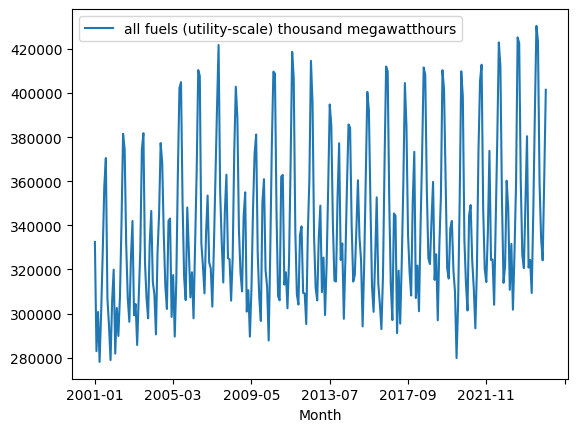

In [7]:
plt.figure(figsize = (20,6))
data.set_index('Month').plot()
plt.show()

In [8]:
new_df = data[data['Month']>='2009-01']
new_df.columns = ['Month','MWH']

<Axes: xlabel='Month'>

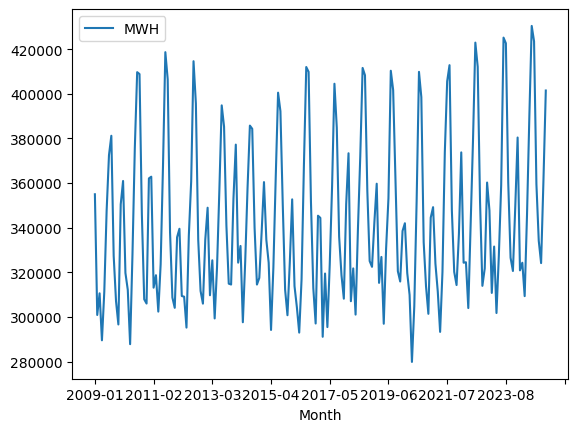

In [9]:
new_df.set_index('Month').plot()

## Weather Data import

In [10]:
weather_data = pd.read_csv('./Weather_US_monthly.csv')

In [11]:
from datetime import datetime
def convert_date(date_str):
    try:
        date_obj = datetime.strptime(date_str, '%Y%m')
        return date_obj.strftime('%Y-%m')
    except ValueError:
        return f"cannot convert: {date_str}"

In [12]:
weather_data.columns = ['Month1', 'temp']

In [13]:
weather_data['Month'] = weather_data['Month1'].apply(lambda x: str(x))

In [14]:
weather_data['Month'] = weather_data['Month'].apply(convert_date)

In [15]:
weather_data.drop('Month1', axis = 1, inplace = True)

<Figure size 2000x600 with 0 Axes>

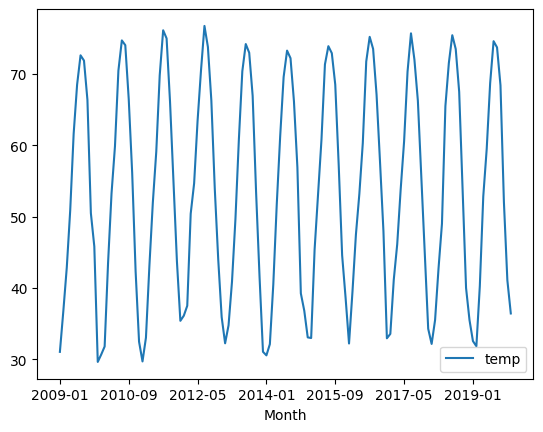

In [16]:
plt.figure(figsize = (20,6))
weather_data.set_index('Month').plot()
plt.show()

## Train-test-split

In [17]:
df_train = new_df[new_df['Month']<='2018-12']
df_test = new_df[(new_df['Month']>'2018-12')&(new_df['Month']<='2019-12')]

In [18]:
df_train = df_train.set_index('Month')
df_test = df_test.set_index('Month')

In [19]:
x1_ts = df_train['MWH']
x2_ts = df_test['MWH']

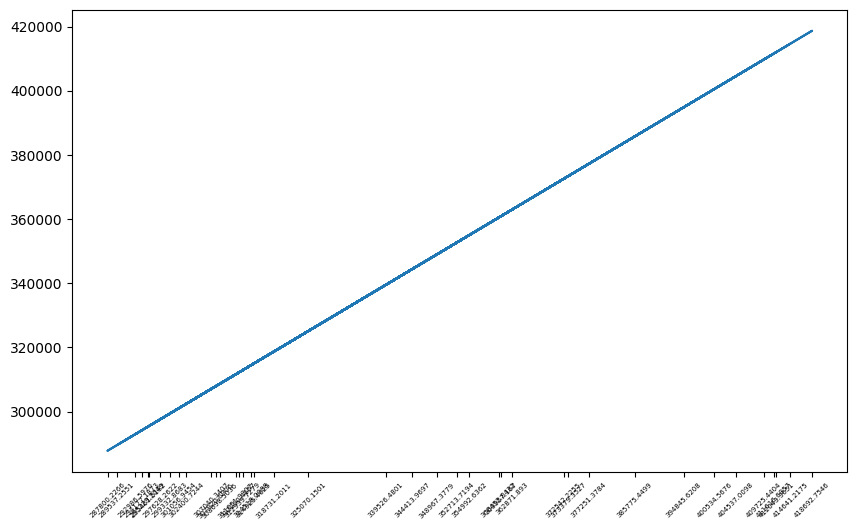

In [20]:
figg, ax = plt.subplots(figsize = (10,6))
ax.plot(x1_ts,x1_ts)
xticks = x1_ts[::3]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45,fontsize = 5)
plt.show()


## Model building (based only on historical time series data)

In [32]:
from arch.unitroot import KPSS

# Perform KPSS test
kpss_test = KPSS(x1_ts)
p_value = kpss_test.pvalue

# Print the results
print(f'p-value: {p_value:.3f}\n')

# Interpret the results
alpha = 0.05
if p_value >= alpha:
     print(f'The time series is stationary (fail to reject "H0: The time series is stationary" at a {100*alpha:.0f}% significance level).')
else: 
    print(f'The time series is not stationary (reject "H0: The time series is stationary" at a {100*alpha:.0f}% significance level).')

p-value: 0.924

The time series is stationary (fail to reject "H0: The time series is stationary" at a 5% significance level).


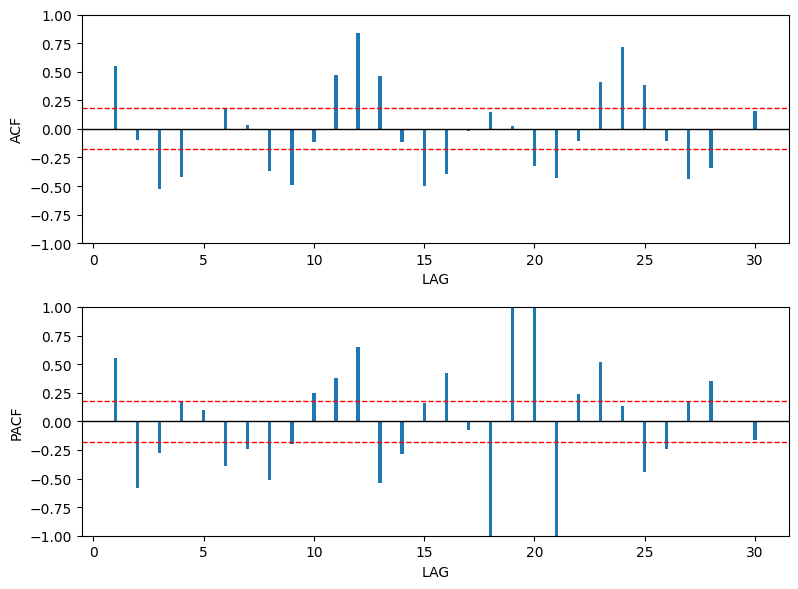

In [33]:
fig, axes = plt.subplots(nrows = 2, figsize = (8,6))

acf1(x1_ts, nlags = 30, ax = axes[0], width = 0.15)
axes[0].set_ylim(-1, 1)

acf1(x1_ts, nlags = 30, ax = axes[1], width = 0.15, pacf = True)
axes[1].set_ylim(-1, 1)

fig.tight_layout()
plt.show()

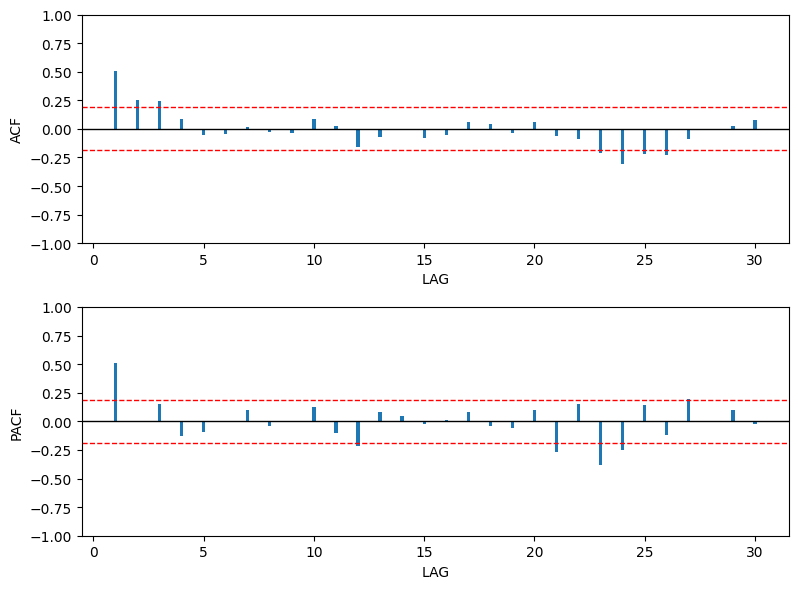

In [34]:
fig, axes = plt.subplots(nrows = 2, figsize = (8,6))

acf1(x1_ts.diff(12).dropna(), nlags = 30, ax = axes[0], width = 0.15)
axes[0].set_ylim(-1, 1)

acf1(x1_ts.diff(12).dropna(), nlags = 30, ax = axes[1], width = 0.15, pacf = True)
axes[1].set_ylim(-1, 1)

fig.tight_layout()
plt.show()

In [35]:
model1 = sm.tsa.arima.ARIMA(x1_ts,order = (1,0,1),seasonal_order=(1,1,1,12)).fit()
print(model1.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                              MWH   No. Observations:                  120
Model:             ARIMA(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -1165.767
Date:                          Mon, 28 Apr 2025   AIC                           2341.533
Time:                                  08:56:29   BIC                           2354.944
Sample:                              01-01-2009   HQIC                          2346.971
                                   - 12-01-2018                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0055      1.775     -0.003      0.998      -3.485       3.474
ma.L1          0.0301      1.808      0.017      0.

In [36]:
model2 = sm.tsa.arima.ARIMA(x1_ts,order = (0,0,1),seasonal_order=(1,1,1,12)).fit()
print(model2.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                              MWH   No. Observations:                  120
Model:             ARIMA(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -1165.288
Date:                          Mon, 28 Apr 2025   AIC                           2338.576
Time:                                  08:56:30   BIC                           2349.304
Sample:                              01-01-2009   HQIC                          2342.926
                                   - 12-01-2018                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0244      0.025      0.967      0.334      -0.025       0.074
ar.S.L12      -0.1238      0.270     -0.459      0.

In [37]:
model3 = sm.tsa.arima.ARIMA(x1_ts,order = (0,0,1),seasonal_order=(0,1,1,12)).fit()
print(model3.summary())

                                    SARIMAX Results                                     
Dep. Variable:                              MWH   No. Observations:                  120
Model:             ARIMA(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1165.533
Date:                          Mon, 28 Apr 2025   AIC                           2337.065
Time:                                  08:56:30   BIC                           2345.112
Sample:                              01-01-2009   HQIC                          2340.328
                                   - 12-01-2018                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0249      0.025      0.993      0.321      -0.024       0.074
ma.S.L12       0.0422      0.011      3.809      0.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [38]:
model4 = sm.tsa.arima.ARIMA(x1_ts,order = (0,0,0),seasonal_order=(0,1,1,12)).fit()
print(model4.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                SARIMAX Results                                 
Dep. Variable:                      MWH   No. Observations:                  120
Model:             ARIMA(0, 1, [1], 12)   Log Likelihood               -1165.747
Date:                  Mon, 28 Apr 2025   AIC                           2335.494
Time:                          08:56:30   BIC                           2340.858
Sample:                      01-01-2009   HQIC                          2337.669
                           - 12-01-2018                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.0447      0.011      4.042      0.000       0.023       0.066
sigma2      1.409e+08   3.08e-13   4.57e+20      0.000    1.41e+08    1.41e+08
Ljung-Box (L1) (Q):                 

In [39]:
k = 12
preds = model4.get_forecast(k)

conf_int = preds.conf_int()

# Create a DataFrame
forecast_df = pd.DataFrame({
    'predicted_mean': preds.predicted_mean,
    'lower_ci': conf_int.iloc[:, 0],
    'upper_ci': conf_int.iloc[:, 1]
})
forecast_df.index = x2_ts.index

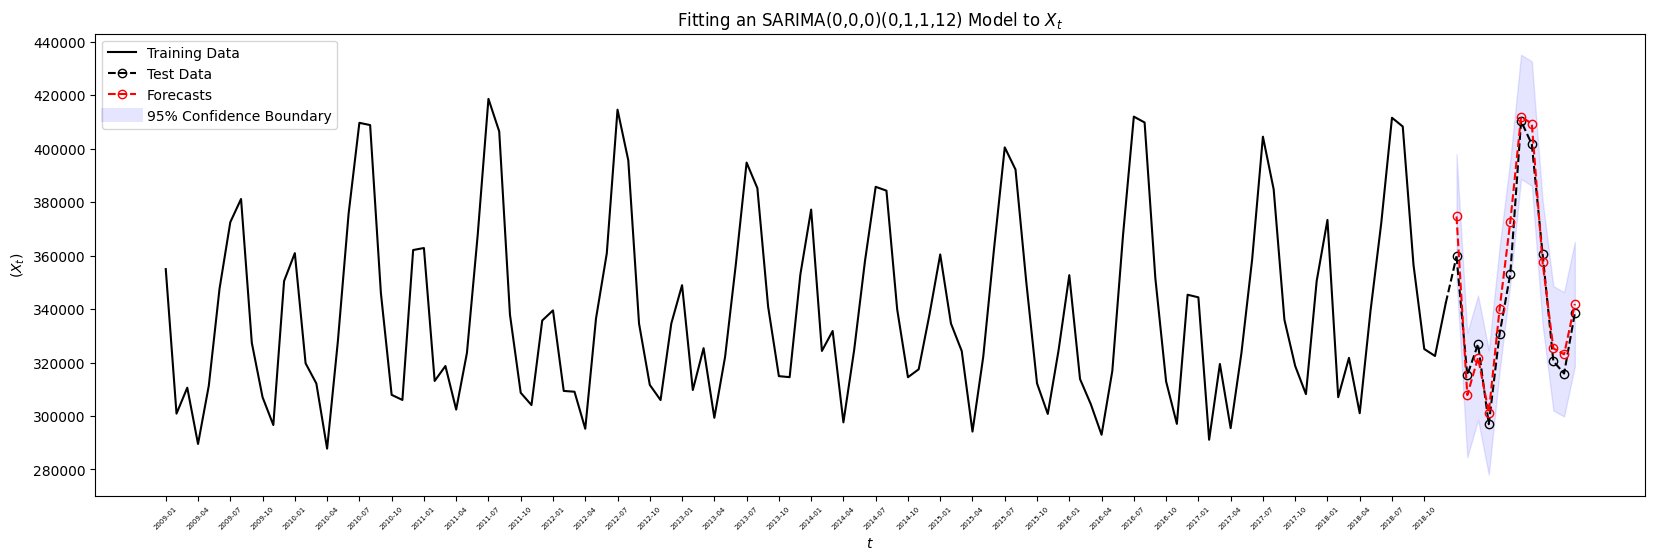

In [40]:
# Plots for U_t

from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize = (20,6))
#plt.figure(figsize = (10, 6))

# Training data plot
ax.plot(df_train.index, df_train, color='black', linestyle='-')

# Test data plot
ax.plot(df_test.index, df_test, color='black', linestyle='--', marker='o', markerfacecolor='none')

# Forecasts plot
ax.plot(forecast_df.index, forecast_df['predicted_mean'], color='red', linestyle='--', marker='o', markerfacecolor='none')

# Confidence boundary plot with lighter shading
ax.fill_between(forecast_df.index, forecast_df['lower_ci'], forecast_df['upper_ci'], color='blue', alpha=0.1)

# Connect the last point of u1_ts to the first point of u2_ts with a black dashed line
ax.plot([df_train.index[-1], df_test.index[0]], [df_train.iloc[-1], df_test.iloc[0]], 'k--')

# Custom legend elements
legend_elements = [
    Line2D([0], [0], color='black', linestyle='-', markeredgecolor='black', label='Training Data'),
    Line2D([0], [0], color='black', linestyle='--', marker='o', markerfacecolor='none', markeredgecolor='black', label='Test Data'),
    Line2D([0], [0], color='red', linestyle='--', marker='o', markerfacecolor='none', markeredgecolor='red', label='Forecasts'),
    Line2D([0], [0], color='blue', alpha=0.1, lw=10, label='95% Confidence Boundary')
]

xticks = df_train.index[::3]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45,fontsize = 5)

plt.title('Fitting an SARIMA(0,0,0)(0,1,1,12) Model to $X_t$')
plt.xlabel('$t$')
plt.ylabel('$(X_t)$')
plt.legend(handles=legend_elements, loc='upper left')
plt.show()


In [41]:
# Calculate the Mean Absolute Percentage Error (MAPE)

errors = np.abs((x2_ts - forecast_df['predicted_mean']) / x2_ts)
mape = np.mean(errors) * 100

print(f'The Mean Absolute Percentage Error (MAPE) is: {mape:.2f}%')


The Mean Absolute Percentage Error (MAPE) is: 2.15%


In [42]:
# Keeping the estimates of the first fitted model

forecast_df_model = forecast_df
mape_model = mape

## Model building (based on historical data and weather data)

In [43]:
weather_data  = weather_data.set_index('Month')
weather_data  = weather_data.reset_index()

In [44]:
weather_data

,Month,temp
0,2009-01,31.05
1,2009-02,36.77
2,2009-03,42.87
3,2009-04,50.90
4,2009-05,61.63
...,...,...
127,2019-08,73.72
128,2019-09,68.41
129,2019-10,52.03
130,2019-11,41.09


In [45]:
new_df2 = pd.merge(left = weather_data, right = new_df, how = 'left', on = 'Month' )

In [46]:
new_df2=new_df2.set_index('Month')
new_df2=new_df2.reset_index()

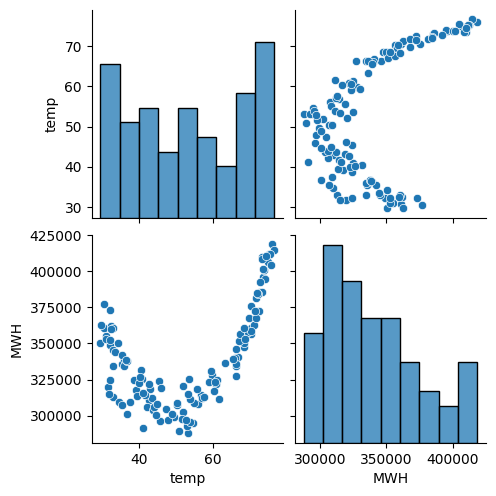

In [47]:
sns.pairplot(new_df2)

In [48]:
weather_data['temp_2'] = weather_data['temp'].apply(lambda x: pow(x,2))

In [49]:
weather_train = weather_data[weather_data['Month'] <= '2018-12']
weather_test = weather_data[(weather_data['Month'] > '2018-12') & (weather_data['Month'] <= '2019-12')]

In [50]:
weather_train = weather_train.set_index('Month')
weather_test = weather_test.set_index('Month')

In [51]:
modeln_1 = sm.tsa.arima.ARIMA(x1_ts, exog=weather_train, order=(1, 0, 1), seasonal_order=(1, 1, 1, 12)).fit()

print(modeln_1.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                              MWH   No. Observations:                  120
Model:             ARIMA(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -1126.578
Date:                          Mon, 28 Apr 2025   AIC                           2267.157
Time:                                  09:01:24   BIC                           2285.932
Sample:                              01-01-2009   HQIC                          2274.769
                                   - 12-01-2018                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp       -1.362e+04   1461.726     -9.315      0.000   -1.65e+04   -1.08e+04
temp_2       135.6666     16.076      8.439      0.

In [52]:
modeln_2 = sm.tsa.arima.ARIMA(x1_ts, exog=weather_train, order=(1, 0, 1), seasonal_order=(0, 1, 1, 12)).fit()

print(modeln_2.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                              MWH   No. Observations:                  120
Model:             ARIMA(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1126.213
Date:                          Mon, 28 Apr 2025   AIC                           2264.426
Time:                                  09:01:25   BIC                           2280.519
Sample:                              01-01-2009   HQIC                          2270.951
                                   - 12-01-2018                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp       -1.362e+04   1400.319     -9.723      0.000   -1.64e+04   -1.09e+04
temp_2       132.9550     15.663      8.489      0.

In [53]:
modeln_3 = sm.tsa.arima.ARIMA(x1_ts, exog=weather_train, order=(0, 0, 1), seasonal_order=(0, 1, 1, 12)).fit()

print(modeln_3.summary())

                                    SARIMAX Results                                     
Dep. Variable:                              MWH   No. Observations:                  120
Model:             ARIMA(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1128.280
Date:                          Mon, 28 Apr 2025   AIC                           2266.561
Time:                                  09:01:25   BIC                           2279.972
Sample:                              01-01-2009   HQIC                          2271.998
                                   - 12-01-2018                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp       -1.362e+04   1456.369     -9.349      0.000   -1.65e+04   -1.08e+04
temp_2       135.6863     16.436      8.256      0.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [54]:
modeln_4 = sm.tsa.arima.ARIMA(x1_ts, exog=weather_train, order=(0, 0, 0), seasonal_order=(0, 1, 1, 12)).fit()

print(modeln_4.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                SARIMAX Results                                 
Dep. Variable:                      MWH   No. Observations:                  120
Model:             ARIMA(0, 1, [1], 12)   Log Likelihood               -1128.747
Date:                  Mon, 28 Apr 2025   AIC                           2265.494
Time:                          09:01:25   BIC                           2276.222
Sample:                      01-01-2009   HQIC                          2269.844
                           - 12-01-2018                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp       -1.362e+04   1084.474    -12.555      0.000   -1.57e+04   -1.15e+04
temp_2       135.6838     12.192     11.129      0.000     111.787     159.580
ma.S.L12       0.0159      0.003    

In [55]:
k = 12
preds2 = modeln_4.get_forecast(steps = k, exog = weather_test)

conf_int2 = preds2.conf_int()

# Create a DataFrame
forecast_df2 = pd.DataFrame({
    'predicted_mean': preds2.predicted_mean,
    'lower_ci': conf_int2.iloc[:, 0],
    'upper_ci': conf_int2.iloc[:, 1]
})

x2_ts.index = pd.to_datetime(x2_ts.index)
forecast_df2.index = pd.to_datetime(forecast_df2.index)
forecast_df_model.index = pd.to_datetime(forecast_df_model.index)

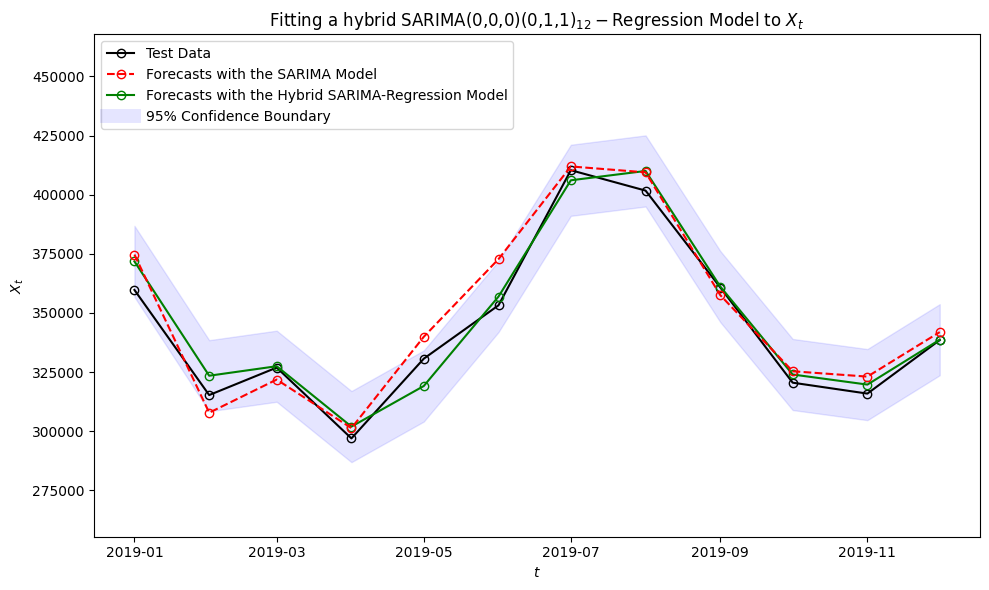

In [56]:
# Plots

from matplotlib.lines import Line2D

plt.figure(figsize = (10, 6))

# Test data plot
plt.plot(x2_ts.index, x2_ts, color='black', linestyle='-', marker='o', markerfacecolor='none')
plt.ylim(min(x2_ts)*0.86, max(x2_ts) * 1.14)

# Forecasts plot
plt.plot(forecast_df2.index, forecast_df2['predicted_mean'], color='green', linestyle='-', marker='o', markerfacecolor='none')

# Forecasts plot
plt.plot(forecast_df_model.index, forecast_df_model['predicted_mean'], color='red', linestyle='--', marker='o', markerfacecolor='none')

# Confidence boundary plot with lighter shading
plt.fill_between(forecast_df2.index, forecast_df2['lower_ci'], forecast_df2['upper_ci'], color='blue', alpha=0.1)

# Custom legend elements
legend_elements = [
    Line2D([0], [0], color='black', linestyle='-', marker='o', markerfacecolor='none', markeredgecolor='black', label='Test Data'),
    Line2D([0], [0], color='red', linestyle='--', marker='o', markerfacecolor='none', markeredgecolor='red', label='Forecasts with the SARIMA Model'),
    Line2D([0], [0], color='green', linestyle='-', marker='o', markerfacecolor='none', markeredgecolor='green', label='Forecasts with the Hybrid SARIMA-Regression Model'),
    Line2D([0], [0], color='blue', alpha=0.1, lw=10, label='95% Confidence Boundary')
]

plt.title('Fitting a hybrid SARIMA(0,0,0)(0,1,1)$_{12}-$Regression Model to $X_t$')
plt.xlabel('$t$')
plt.ylabel('$X_t$')
plt.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

In [58]:
# Calculate the Mean Absolute Percentage Error (MAPE)

errors2 = np.abs((x2_ts - forecast_df2['predicted_mean']) / x2_ts)
mape2 = np.mean(errors2) * 100

print(f'The Mean Absolute Percentage Error (MAPE) is: {mape2:.2f}%')

The Mean Absolute Percentage Error (MAPE) is: 1.49%


In [59]:
# Calculating percentage improvement

per_improvement = (mape_model - mape2)/mape_model * 100
print(f'The percentage improvement in MAPE from the SARIMA Model 2 to the hybrid SARIMA-regression Model 5 is: {per_improvement:.2f}%')


The percentage improvement in MAPE from the SARIMA Model 2 to the hybrid SARIMA-regression Model 5 is: 30.81%
